In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import trompy as tp

from scipy import stats

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", [colors[1], "white", colors[3]])
custom_cmap = sns.color_palette("icefire", as_cmap=True)
custom_cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [2]:
with open(DATAFOLDER / "bazzino_data.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [3]:
def smooth_array(arr, window_size=5):
    """
    Smooth a 2D array along one dimension using a moving average.
    
    :param arr: 2D NumPy array
    :param window_size: Size of the smoothing window
    :return: Smoothed 2D array
    """
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=1, arr=arr)
    return smoothed

# Example usage
snips_vel = smooth_array(snips_vel, window_size=5)

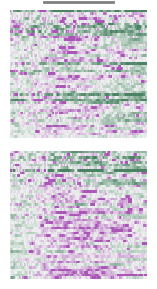

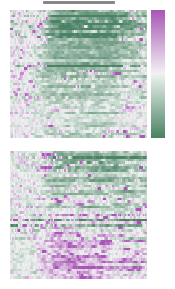

In [4]:
def get_heatmap_data(snips, x_array, condition, infusiontype):

    query_string = "condition == @condition & infusiontype == @infusiontype"

    heatmap_data = []
    df = x_array.query(query_string)
    for trial in df.trial.unique():
        tmp_snips = snips[x_array.query(query_string + " & trial == @trial").index]
        mean_snip = np.nanmean(tmp_snips, axis=0)
        heatmap_data.append(mean_snip)
        
    return np.array(heatmap_data)

def init_figure():
    f = plt.figure(figsize=(2, 3.5))
    gs = f.add_gridspec(2, 2, hspace=0.1, wspace=0.05, width_ratios=[10, 1])
    
    ax1 = f.add_subplot(gs[0, 0])
    ax2 = f.add_subplot(gs[1, 0])
    cbar_ax = f.add_subplot(gs[0, 1])
    
    return f, ax1, ax2, cbar_ax

def make_heatmap(data, ax, vlim, cbar_ax=None, inf_bar=False, cmap=custom_cmap):
    
    if cbar_ax is not None:
        cbar=True
    else:
        cbar=False
        
    sns.heatmap(np.array(data),
                cmap=cmap,
                ax=ax,
                cbar=cbar,
                cbar_ax=cbar_ax,
                vmin=-vlim, vmax=vlim
                )
    
    if cbar_ax is not None:
        cbar_ax.set_yticks([])
    
    if inf_bar:
        ax.plot([50,150], [-3, -3], color="black", lw=2, alpha=0.5, clip_on=False)
        
    ax.set_xticks([])
    ax.set_yticks([])

vlim = 4.5
# savefigs = True

# custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", [colors[1], "white", colors[3]])

# replete
f, ax1, ax2, cbar_ax = init_figure()

heatmap_data = get_heatmap_data(snips_vel, x_array, "replete", "10NaCl")
replete_10_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax1, vlim, inf_bar=True,
             # cmap=sns.light_palette("#016895", as_cmap=True)
             )

heatmap_data = get_heatmap_data(snips_vel, x_array, "replete", "45NaCl")
replete_45_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax2, vlim,
             # cbar_ax=cbar_ax,
             # cmap=sns.light_palette("#016895", as_cmap=True)
             )

cbar_ax.remove()

if savefigs:
    f.savefig(FIGSFOLDER / "heatmap_vel_replete.pdf")

# deplete
f, ax1, ax2, cbar_ax = init_figure()

heatmap_data = get_heatmap_data(snips_vel, x_array, "deplete", "10NaCl")
deplete_10_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax1, vlim, inf_bar=True,
             # cmap=sns.light_palette("#C74632", as_cmap=True)
             )

heatmap_data = get_heatmap_data(snips_vel, x_array, "deplete", "45NaCl")
deplete_45_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax2, vlim, cbar_ax=cbar_ax,
             # cmap=sns.light_palette("#C74632", as_cmap=True)
             )

if savefigs:
    f.savefig(FIGSFOLDER / "heatmap_vel_deplete.pdf")


C:\Users\jmc010\AppData\Local\Temp\ipykernel_29656\3777079420.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc.append(np.trapz(snip[50:150]))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_29656\3777079420.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc.append(np.trapz(snip[50:150]))


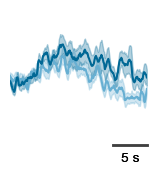

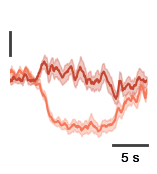

In [5]:
def get_mean_snips(snips, x_array, condition):

    query_string = "condition == @condition"

    snips_10, snips_45 = [], []
    for id in x_array.query(query_string + " & infusiontype == '10NaCl'").id.unique():
        snips_10.append(np.nanmean(snips[x_array.query(query_string + " & id == @id").index], axis=0))
    for id in x_array.query(query_string + " & infusiontype == '45NaCl'").id.unique():
        snips_45.append(np.nanmean(snips[x_array.query(query_string + " & id == @id").index], axis=0))
        
    return np.array(snips_10), np.array(snips_45)

def init_figure():
    f = plt.figure(figsize=(2, 2))
    gs = f.add_gridspec(1, 2, hspace=0.1, wspace=0.05, width_ratios=[10, 1], bottom=0.2)
    ax = f.add_subplot(gs[0, 0])
    
    return f, ax
    
def plot_snips(snips_10, snips_45, ax, colors_10, colors_45, ylims, scalebar=False):
    for snips, col in zip([snips_10, snips_45], [colors_10, colors_45]):
        x = np.arange(snips.shape[1]) / 10
        mean = np.mean(snips, axis=0)
        sd = np.std(snips, axis=0)
        sem = sd / np.sqrt(snips.shape[0])
        
        ax.plot(x, mean, color=col, lw=1.5)
        ax.fill_between(x, mean-sem, mean+sem, alpha=0.3, color=col)
        
        sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_xlim([0, 20])
        ax.set_ylim(ylims)
        ax.plot([15,20], [ylims[0], ylims[0]], color="black", lw=2, alpha=0.5, clip_on=False)
        ax.text(17.5, ylims[0]-0.3, "5 s", ha="center", va="top", fontsize=10)
        
        if scalebar:
            ax.plot([0, 0], [1, 2], color="black", lw=2, alpha=0.5, clip_on=False)
        
def get_auc(snips):
    auc = []
    for snip in snips:
        auc.append(np.trapz(snip[50:150]))
    return np.array(auc)

# savefigs = False
ylims = [-3, 3]

# replete
f, ax = init_figure()

snips_10, snips_45 = get_mean_snips(snips_vel, x_array, "replete")
plot_snips(snips_10, snips_45, ax, colors[0], colors[1], ylims)
replete_aucs = [get_auc(snips_10), get_auc(snips_45)]

if savefigs:
    f.savefig(FIGSFOLDER / "snips_vel_replete.pdf")

# deplete
f, ax = init_figure()

snips_10, snips_45 = get_mean_snips(snips_vel, x_array, "deplete")
plot_snips(snips_10, snips_45, ax, colors[2], colors[3], ylims, scalebar=True)
deplete_aucs = [get_auc(snips_10), get_auc(snips_45)]

if savefigs:
    f.savefig(FIGSFOLDER / "snips_vel_deplete.pdf")
    

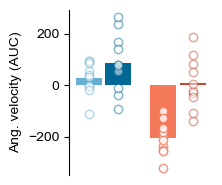

In [6]:
f, ax = plt.subplots(figsize=(2.2, 2.2),
                     gridspec_kw={"left": 0.3, "right": 0.95, "top": 0.95, "bottom": 0.2})


aucs = [replete_aucs, deplete_aucs]
barx = [1, 2]
barwidth=0.35

spacer = 0.2
ax.bar(barx[0] - spacer, np.mean(aucs[0][0]), color=colors[0], width=barwidth)
ax.bar(barx[0] + spacer, np.mean(aucs[0][1]), color=colors[1], width=barwidth)

ax.bar(barx[1] - spacer, np.mean(aucs[1][0]), color=colors[2], width=barwidth)
ax.bar(barx[1] + spacer, np.mean(aucs[1][1]), color=colors[3], width=barwidth)

ax.scatter([barx[0] - spacer]*len(aucs[0][0]), aucs[0][0], facecolors="white", edgecolors=colors[0], alpha=0.5)
ax.scatter([barx[0] + spacer]*len(aucs[0][1]), aucs[0][1], facecolors="white", edgecolors=colors[1], alpha=0.5)
ax.scatter([barx[1] - spacer]*len(aucs[1][0]), aucs[1][0], facecolors="white", edgecolors=colors[2], alpha=0.8)
ax.scatter([barx[1] + spacer]*len(aucs[1][1]), aucs[1][1], facecolors="white", edgecolors=colors[3], alpha=0.5)

sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
ax.set_xticks([])
#ax.set_yticks([-300, -200, -100, 0, ])
#ax.set_ylim([-290,200])

ax.set_ylabel("Ang. velocity (AUC)", fontsize=10)

if savefigs:
    f.savefig(FIGSFOLDER / "aucs_vel.pdf")

r = 0.04, p = 0.759
r = 0.63, p = 0.000
r = 0.80, p = 0.000
r = 0.81, p = 0.000


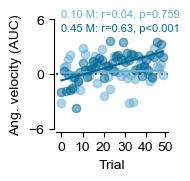

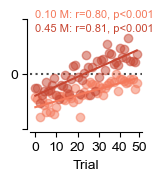

In [18]:
savefigs = True

def draw_regression_line(y, ax, color):
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_fit = slope * x + intercept
    ax.plot(x, y_fit, color=color, lw=1.5)
    
    print(f"r = {r_value:.2f}, p = {p_value:.3f}")
    
    return r_value, p_value

def make_correlation_plot(inf10, inf45, col10, col45, yaxis=False):
    
    f, ax = plt.subplots(figsize=(1.8,1.8),
                         gridspec_kw={"left": 0.28, "right": 0.9, "top": 0.85, "bottom": 0.24})

    ax.scatter(np.arange(len(inf10)), inf10, color=col10, alpha=0.5)
    ax.scatter(np.arange(len(inf45)), inf45, color=col45, alpha=0.5)

    r, p = draw_regression_line(inf10, ax, col10)
    if p < 0.001:
        p = "p<0.001"
    else:
        p = f"p={p:.3f}"
    ax.text(0, 6, f"0.10 M: r={r:.2f}, {p}", color=col10, fontsize=8,
            va="bottom", ha="left")
    r, p = draw_regression_line(inf45, ax, col45)
    if p < 0.001:
        p = "p<0.001"
    else:
        p = f"p={p:.3f}"
    ax.text(0, 4.5, f"0.45 M: r={r:.2f}, {p}", color=col45, fontsize=8,
            va="bottom", ha="left")

    sns.despine(ax=ax, offset=2)

    ax.set_ylim([-6, 6])
  
    if yaxis:
        ax.set_yticks([-6, 0, 6])
        ax.set_ylabel("Ang. velocity (AUC)")
    else:
        ax.set_yticks([-6, 0, 6], labels=["", "0", "",])

    ax.set_xticks([0, 10, 20, 30, 40, 49], labels=["0", "10", "20", "30", "40", "50"])
    ax.set_xlabel("Trial")

    ax.axhline(0, color="k", linestyle=":", alpha=0.7, zorder=-20)
    
    return f
    
f = make_correlation_plot(replete_10_inf, replete_45_inf, colors[0], colors[1], yaxis=True)
if savefigs:
    f.savefig(FIGSFOLDER / "correlation_vel_replete.pdf")
    
f = make_correlation_plot(deplete_10_inf, deplete_45_inf, colors[2], colors[3])
if savefigs:
    f.savefig(FIGSFOLDER / "correlation_vel_deplete.pdf")
    


In [26]:
auc_snips = snips_photo[:, 50:150].mean(axis=1)
auc_vel = snips_vel[:, 50:150].mean(axis=1)
auc_vel.shape, auc_snips.shape

((1960,), (1960,))

(-15.0, 15.0)

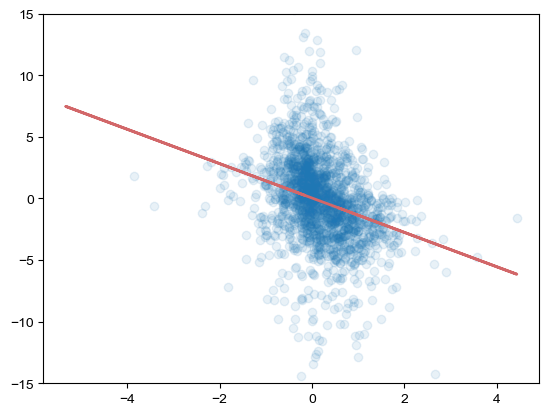

In [27]:
df = pd.DataFrame({"auc_snips": auc_snips, "auc_vel": auc_vel}).dropna(axis='rows')

f, ax = plt.subplots()
ax.scatter(df.auc_snips, df.auc_vel, alpha=0.1)

x = df.auc_snips
y = df.auc_vel
color = "#D26769"

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_fit = slope * x + intercept
ax.plot(x, y_fit, color=color, lw=2)

ax.set_ylim([-15, 15])

In [28]:
slope, intercept, r_value, p_value, std_err

(np.float64(-1.3953412670708998),
 np.float64(0.035631676087621245),
 np.float64(-0.24860156231966832),
 np.float64(5.40950816012912e-29),
 np.float64(0.12286192686848357))

In [22]:
df = pd.DataFrame({"auc_snips": auc_snips, "auc_vel": auc_vel})

In [23]:
df2 = pd.concat([x_vel, df], axis=1)

In [24]:
snips_vel.shape

(1960, 200)

In [29]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define a sigmoidal function (logistic function)
def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L: Maximum value of the curve
    x0: Midpoint of the sigmoid
    k: Steepness of the curve
    b: Baseline offset
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

df2_dep_45 = df2.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

snips_x0 = []
snips_k = []
for id in df2_dep_45.id.unique():

    tmp = df2_dep_45.query("id == @id")
    f, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.plot(tmp.trial, tmp.auc_snips, color=colors[2], alpha=0.5)

    x = tmp.trial.values
    y = tmp.auc_snips.values

    # Fit the sigmoid function to the data
    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)])
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[2], lw=2)
        
        print(f"id: {id}, params: {popt}")
        snips_x0.append(popt[1])  # x0 is the second parameter in popt
        snips_k.append(popt[2])  # k is the third parameter in popt
    except RuntimeError as e:
        print(f"Could not fit sigmoid for id {id}: {e}")
        snips_x0.append(np.nan)  # Append NaN if fitting fails
        snips_k.append(np.nan)
snips_x0 = np.array(snips_x0)
snips_k = np.array(snips_k)


NameError: name 'df2' is not defined

id: PB26, params: [ 5.86016629 25.06342815  0.29173752 -3.11533029]
id: PB27, params: [ 33.81655471 -10.44260419   6.58961533 -31.9359272 ]
id: PB30, params: [-4.82403413 25.89972366 -0.32193159  1.21784083]
id: PB31, params: [15.72629172 29.57301116  0.0547686  -7.05604575]
Could not fit sigmoid for id PB46: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
id: PB48, params: [ 4.15758054 22.98100414 22.11702496 -1.34386248]
id: PB71, params: [ 3.9582298   6.84617814  1.30739004 -3.81163678]
id: PB72, params: [-4.57382597 31.82576681 -0.30021941  3.07656785]
id: PB73, params: [ 2.42535114 23.51900555 26.84719499 -2.30895066]
id: PB75, params: [-4.96359055 27.51751906 -0.12289728  3.33794372]


C:\Users\jmc010\AppData\Local\Temp\ipykernel_13100\556388516.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)])
C:\Users\jmc010\AppData\Local\Temp\ipykernel_13100\556388516.py:14: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b


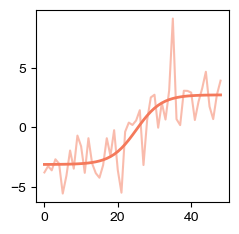

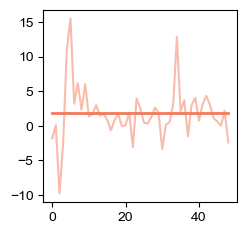

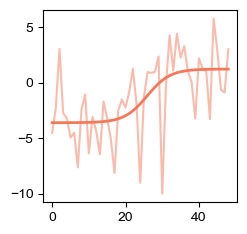

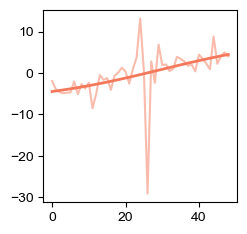

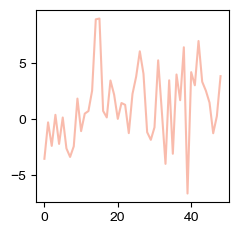

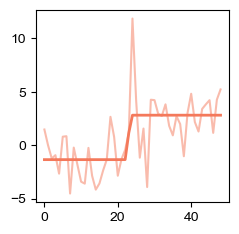

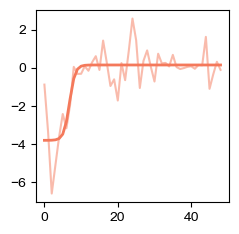

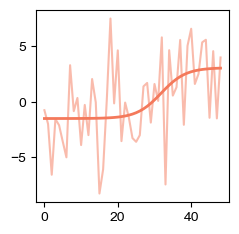

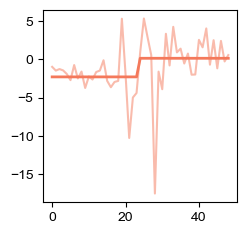

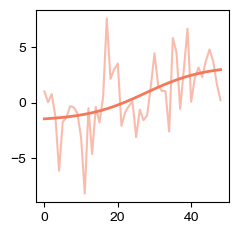

In [37]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define a sigmoidal function (logistic function)
def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L: Maximum value of the curve
    x0: Midpoint of the sigmoid
    k: Steepness of the curve
    b: Baseline offset
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

df2_dep_45 = df2.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

vel_x0 = []
vel_k = []
for id in df2_dep_45.id.unique():

    tmp = df2_dep_45.query("id == @id")
    f, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.plot(tmp.trial, tmp.auc_vel, color=colors[2], alpha=0.5)

    x = tmp.trial.values
    y = tmp.auc_vel.values

    # Fit the sigmoid function to the data
    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)])
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[2], lw=2)
        
        print(f"id: {id}, params: {popt}")
        vel_x0.append(popt[1])  # x0 is the second parameter in popt
        vel_k.append(popt[2])  # k is the third parameter in popt
    except RuntimeError as e:
        print(f"Could not fit sigmoid for id {id}: {e}")
        vel_x0.append(np.nan)
        vel_k.append(np.nan)
vel_x0 = np.array(vel_x0)
vel_k = np.array(vel_k)


In [35]:
vel_x0

array([ 25.06342815, -10.44260419,  25.89972366,  29.57301116,
                nan,  22.98100414,   6.84617814,  31.82576681,
        23.51900555,  27.51751906])

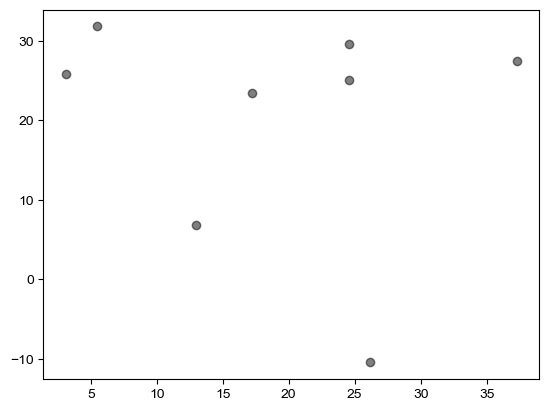

In [36]:
plt.scatter(snips_x0, vel_x0, alpha=0.5, color="black")

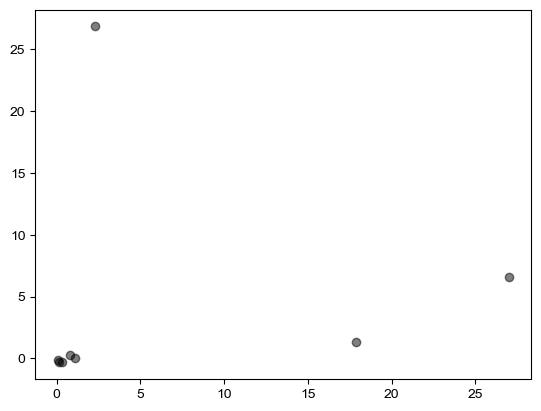

In [40]:
plt.scatter(snips_k, vel_k, alpha=0.5, color="black")

In [73]:
import matplotlib.colors as mcolors
import colorsys

def hex_to_hue_deg(hex_color):
    rgb = mcolors.hex2color(hex_color)  # (r, g, b) in 0-1
    h, l, s = colorsys.rgb_to_hls(*rgb) # h in 0-1
    return h * 360

# Example: get the hue degree for your hex colors
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
for hex_color in colors:
    hue = hex_to_hue_deg(hex_color)
    print(f"{hex_color}: hue={hue:.1f}°")

#67AFD2: hue=199.6°
#016895: hue=198.2°
#F4795B: hue=11.8°
#C74632: hue=8.1°


(0.0, 360.0)

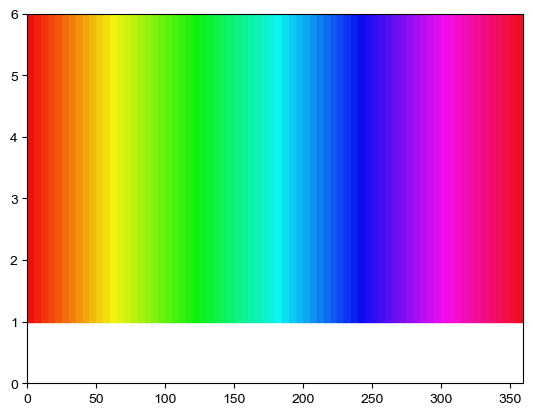

In [86]:
import colorsys

f, ax = plt.subplots()

for h in np.arange(0, 360, 5):
    rgb = colorsys.hls_to_rgb(h/360, 0.5, 0.9)  # Convert hue to RGB
    ax.add_patch(plt.Rectangle((h, 1), 5, 5, color=rgb))

ax.set_ylim([0, 6])
ax.set_xlim([0, 360])


